In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import spacy for NLP and re for regular expressions
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

import pickle
# import sklearn transformers, models and pipelines
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

# Load the small language model from spacy
nlp = spacy.load('en_core_web_sm')

# set pandas text output to 400
pd.options.display.max_colwidth = 400

In [2]:
df_fin_phrase = pd.read_csv("../../Data/Prepared/CleanDatasets/fin_phrase_bank_clean.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_fin_phrase['clean_text'], df_fin_phrase['label'], test_size=0.3, random_state=42)

In [4]:
# Load the en_core_web_lg model
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])
docs_train = [nlp(str(doc)).vector for doc in X_train]
X_train = np.vstack(docs_train)
print('Shape of train set: {}'.format(X_train.shape))


Shape of train set: (3392, 300)


In [5]:
docs_test = [nlp(doc).vector for doc in X_test]
X_test = np.vstack(docs_test)
print('Shape of test set: {}'.format(X_test.shape))

Shape of test set: (1454, 300)


In [6]:
word2vec_pipe = Pipeline([('estimator', LogisticRegression(C=1e3, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4, max_iter=10000))])



In [7]:
# cross validate
print('F1 score: {:.3f}'.format(np.mean(cross_val_score(word2vec_pipe, X_train, y_train, scoring = 'f1_micro'))))

F1 score: 0.691


In [8]:
# fit pipeline
word2vec_pipe.fit(X_train, y_train)

# predict on test set
pred = word2vec_pipe.predict(X_test)



In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_fin_phrase['clean_text'], df_fin_phrase['label'], test_size=0.3, random_state=42)

In [10]:
df = pd.DataFrame({'text': X_test, 'truelabelNum': y_test, 'prediclabelNum': pred})
# class 0: negative, class 1: neutral, class 2: positive
df['pred_label'] = df['truelabelNum'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
df['true_label'] = df['prediclabelNum'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [11]:
df.to_csv('../../Data/Prepared/Word2vecAnalysis/FinancialWord2vecLogicReg.csv', index=False)

# Testing the model

In [12]:
sentences = ['growth is strong and we have plenty of liquidity.', 
               'there is a shortage of capital, and we need extra financing.', 
              'formulation patents might protect Vasotec to a limited extent.']
for sen in sentences:
    sentences_vector = [nlp(str(doc)).vector for doc in sentences]# vectorizing
    if word2vec_pipe.predict(sentences_vector).prod() == 0:
        print('Negative')
    elif word2vec_pipe.predict(sentences_vector).prod() == 1:
        print('Neutral')
    else:
        print('Positive')

Neutral
Neutral
Neutral


In [13]:

filename = '../../Data/Models/FinancialLogitRec_word2vec.pt'
pickle.dump(word2vec_pipe, open(filename, 'wb'))

# Testing the model with Twitter data

In [14]:
df_train = pd.read_csv("../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv")
df_test = pd.read_csv("../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv")

In [15]:
df_train.dropna( inplace=True)
df_test.dropna( inplace=True)

In [16]:
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])
docs_train = [nlp(str(doc)).vector for doc in df_train['clean_text']]
X_train = np.vstack(docs_train)
print('Shape of train set: {}'.format(X_train.shape))

Shape of train set: (16989, 300)


In [17]:
docs_test = [nlp(doc).vector for doc in df_test['clean_text']]
X_test = np.vstack(docs_test)
print('Shape of test set: {}'.format(X_test.shape))

Shape of test set: (4117, 300)


In [18]:
y_train = df_train['label']
y_test = df_test['label']

In [19]:
# cross validate
print('F1 score: {:.3f}'.format(np.mean(cross_val_score(word2vec_pipe, X_train, y_train, scoring = 'f1_micro'))))

F1 score: 0.636


In [20]:
# fit pipeline
word2vec_pipe.fit(X_train, y_train)

# predict on test set
pred = word2vec_pipe.predict(X_test)


In [21]:
from sklearn.metrics import accuracy_score, classification_report

In [22]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.716298275443284


In [23]:
# Assuming y_test and y_pred are already defined
report = classification_report(y_test, pred, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Optionally, you can reset the index to have the labels as a column
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'class'}, inplace=True)

print(report_df)

           class  precision    recall  f1-score      support
0              0   0.544118  0.506849  0.524823    73.000000
1              1   0.748691  0.668224  0.706173   214.000000
2              2   0.725934  0.752347  0.738905   852.000000
3              3   0.671053  0.662338  0.666667    77.000000
4              4   0.900990  0.938144  0.919192    97.000000
5              5   0.851562  0.900826  0.875502   242.000000
6              6   0.713333  0.732877  0.722973   146.000000
7              7   0.764331  0.750000  0.757098   160.000000
8              8   0.523810  0.687500  0.594595    32.000000
9              9   0.606936  0.625000  0.615836   336.000000
10            10   0.473684  0.692308  0.562500    13.000000
11            11   0.062500  0.071429  0.066667    14.000000
12            12   0.685484  0.714286  0.699588   119.000000
13            13   0.629213  0.482759  0.546341   116.000000
14            14   0.689737  0.696386  0.693046   415.000000
15            15   0.690

# Confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

In [29]:
class_names = sorted(df_train.label.unique())
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [27]:
cm = confusion_matrix(y_test, pred)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

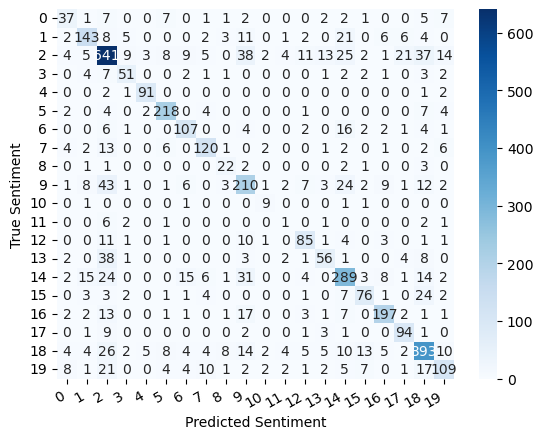

In [30]:
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)